# <h1><center> COMMUNICATION THROUGH DATA and STORY THROUGH VISUALIZATION </center></h1>

## <h1><center> “Time Series Analysis” to Forecast Crashes and Traffic Violations in Montgomery County, MD  </center></h1>


### Meenakshi Nerolu           
### Date: Dec 1, 2020

# Importing Libraries

In [1]:
## import packages:
import warnings
warnings.filterwarnings('ignore')

import numpy as np # for vector operations
from numpy import percentile
import pandas as pd # for Data Frame methods
import pandas.util.testing as tm
import matplotlib.pyplot as plt # Two dimensional plotting library
import matplotlib as mpl
import seaborn as sns #  library for making statistical graphics
import plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.express as px
from plotly import tools

#sklearn
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.svm import SVC, LinearSVC
from sklearn.utils import resample
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import scikitplot as skplt

# 1.Traffic Violation <a class="anchor" id="sec3"></a> 

## Reading "Traffic_Violations" data

In [2]:
    # Reading csv file
    #traffic = pd.read_csv("Traffic_Violations.csv",low_memory=False)
    
    ## Downloading & Reading csv file from website
    url = 'https://data.montgomerycountymd.gov/api/views/4mse-ku6q/rows.csv?accessType=DOWNLOAD'
    traffic = pd.read_csv(url,low_memory=False)

In [3]:
"""" UseFeatues() Function when called, returns a dataframe with additional features"""

def useFeatures(traffic):

    ## Formatting the Date
    ## Replace white space everywhere
    traffic.columns = traffic.columns.str.replace(' ', '')
    # Confirm the date column is in datetime format
    traffic['DateOfStop'] = pd.to_datetime(traffic['DateOfStop'])

    # Confirm the  time column is in datetime format
    traffic['TimeOfStop'] = pd.to_datetime(traffic['TimeOfStop'])
    # creating  new columns: date, year, month, day, time 
    traffic['date'] = pd.to_datetime(traffic['DateOfStop'])
    traffic['year'] = traffic['DateOfStop'].dt.year
    traffic['month'] = traffic['DateOfStop'].dt.month
    traffic['time'] = traffic['TimeOfStop'].dt.time
    traffic['hour'] = traffic['TimeOfStop'].dt.hour
    #traffic['day'] = traffic['DateOfStop'].dt.weekday_name
    traffic['day'] = traffic['DateOfStop'].dt.day_name()
    traffic = traffic.sort_values(by='date')
    

    
    ## Filtering the Desired Date Range - 2015 to 2020 ##
    traffic = traffic[traffic.date >='01/01/2015']
    traffic = traffic[traffic.date <'12/01/2020']
    traffic = traffic.reset_index(drop=True)
    
    traffic['season']= "Fall"
    traffic.loc[(traffic['month'] < 3) | (traffic['month'] >= 12), "season"] = 'Winter'
    traffic.loc[(traffic['month'] < 6) & (traffic['month'] >= 3), "season"] = 'Spring'
    traffic.loc[(traffic['month'] < 9) & (traffic['month'] >= 6), "season"] = 'Summer'
    
    ## Hour status
    ##traffic["hourStatus"] = "Evening"
    ## traffic.loc[( traffic["hour"] < 18) & ( traffic["wdayStatus"] == "Weekday"), "hourStatus"]="WorkHour"
    
    #Creating a new column to count the total number of violation
    traffic['Violation'] = pd.Series(1, index=traffic.index)
    
    return traffic

In [4]:
# All the above features are stored in new data frame "traffic_features"
traffic_features = useFeatures(traffic)

In [5]:
traffic_features.head()

,SeqID,DateOfStop,TimeOfStop,Agency,SubAgency,Description,Location,Latitude,Longitude,Accident,...,ArrestType,Geolocation,date,year,month,time,hour,day,season,Violation
0,483fa133-119b-4bad-80bd-280604f79b76,2015-01-01,2020-12-06 06:12:00,MCP,"4th District, Wheaton",DRIVING WHILE IMPAIRED BY ALCOHOL,VEIRS MILL RD @ ENNALLS AVE,39.058653,-77.047795,No,...,A - Marked Patrol,"(39.0586533333333, -77.047795)",2015-01-01,2015,1,06:12:00,6,Thursday,Winter,1
1,29a84c0e-a872-4ef7-86ae-fcbd14217f29,2015-01-01,2020-12-06 00:57:00,MCP,"3rd District, Silver Spring",FAILURE OF VEH. ON HWY. TO DISPLAY LIGHTED LAM...,COLESVILLE RD/SPRING ST,39.002607,-77.024447,No,...,A - Marked Patrol,"(39.0026066666667, -77.0244466666667)",2015-01-01,2015,1,00:57:00,0,Thursday,Winter,1
2,d40bf56b-354a-4138-ba36-20b493422af8,2015-01-01,2020-12-06 19:50:00,MCP,"2nd District, Bethesda",FAILURE OF VEH. ON HWY. TO DISPLAY LIGHTED LAM...,OLD GEORGETOWN RD X MAPLE RIDGE RD,38.992105,-77.106178,No,...,A - Marked Patrol,"(38.992105, -77.1061783333333)",2015-01-01,2015,1,19:50:00,19,Thursday,Winter,1
3,972354e5-6b95-4267-ae05-940d006f39bb,2015-01-01,2020-12-06 05:08:00,MCP,"4th District, Wheaton",DRIVING VEHICLE WHILE UNDER THE INFLUENCE OF A...,CONNECTICUT AT DEAN,39.061860,-77.044693,No,...,A - Marked Patrol,"(39.06186, -77.0446933333333)",2015-01-01,2015,1,05:08:00,5,Thursday,Winter,1
4,8d7b7d83-add0-429a-bd9d-a31c2f5ee161,2015-01-01,2020-12-06 20:44:00,MCP,"2nd District, Bethesda",DRIVER MAKING IMPROPER TURN AT INTERSECTION,OLD GEORGETOWN RD X RYLAND DR,39.012315,-77.116558,No,...,A - Marked Patrol,"(39.012315, -77.1165583333333)",2015-01-01,2015,1,20:44:00,20,Thursday,Winter,1


## Replace Yes or No by 0 

In [6]:
    ## Replace Yes and No by 1 and 0 respectively
traffic_replace = traffic_features.replace( {'Yes' : 1, 'No' : 0})
    
   
    ## replace the column name Year by Year_model
traffic_replace = traffic_replace.rename(columns={"Year":"Year_model"})
    
    # Delete the following columns as these columns have the highest number of NA's
delete_columns = traffic_replace[['SeqID', 'SearchConducted', 'SearchDisposition', 'SearchOutcome' , 'SearchReason', 'SearchReasonForStop', 'SearchType', 'SearchArrestReason']]
    
    # Delete these columns from the data frame, traffic_new
traffic_new = traffic_replace.drop(delete_columns ,axis=1)

In [7]:
traffic_new["Color"].value_counts()

BLACK          240027
SILVER         207108
WHITE          182930
GRAY           136996
RED             85330
BLUE            80796
GREEN           31595
GOLD            30917
BLUE, DARK      24114
TAN             19433
MAROON          17478
BLUE, LIGHT     13211
BEIGE           10991
GREEN, DK        9649
GREEN, LGT       5321
BROWN            4676
YELLOW           3977
ORANGE           3721
BRONZE           2414
PURPLE           1944
MULTICOLOR        760
CREAM             546
COPPER            347
PINK              148
CHROME             30
CAMOUFLAGE         26
Name: Color, dtype: int64

In [8]:
#rename the colors :
traffic_new = traffic_new.replace({"BLUE, DARK":"BLUE" , "BLUE, LIGHT":"BLUE", "GREEN, DK":"GREEN", "GREEN, LGT":"GREEN" })
traffic_new.head()
print("Size of the data frame : ", traffic_new.shape)
#info() is used to check the Information about the data and the datatypes of each respective attribute.
print("Summary of columns ", traffic_new.info(verbose = False))
#This code prints a summary of columns count and its dtypes but not per column information.
print("\n\nThe column names in the dataframe \n\n :", traffic_new.columns)

Size of the data frame :  (1126056, 43)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1126056 entries, 0 to 1126055
Columns: 43 entries, DateOfStop to Violation
dtypes: bool(1), datetime64[ns](3), float64(3), int64(14), object(22)
memory usage: 361.9+ MB
Summary of columns  None


The column names in the dataframe 

 : Index(['DateOfStop', 'TimeOfStop', 'Agency', 'SubAgency', 'Description',
       'Location', 'Latitude', 'Longitude', 'Accident', 'Belts',
       'PersonalInjury', 'PropertyDamage', 'Fatal', 'CommercialLicense',
       'HAZMAT', 'CommercialVehicle', 'Alcohol', 'WorkZone', 'State',
       'VehicleType', 'Year_model', 'Make', 'Model', 'Color', 'ViolationType',
       'Charge', 'Article', 'ContributedToAccident', 'Race', 'Gender',
       'DriverCity', 'DriverState', 'DLState', 'ArrestType', 'Geolocation',
       'date', 'year', 'month', 'time', 'hour', 'day', 'season', 'Violation'],
      dtype='object')


In [9]:
traffic_final = traffic_new.fillna(method='ffill')

In [10]:
traffic_final.head()

,DateOfStop,TimeOfStop,Agency,SubAgency,Description,Location,Latitude,Longitude,Accident,Belts,...,ArrestType,Geolocation,date,year,month,time,hour,day,season,Violation
0,2015-01-01,2020-12-06 06:12:00,MCP,"4th District, Wheaton",DRIVING WHILE IMPAIRED BY ALCOHOL,VEIRS MILL RD @ ENNALLS AVE,39.058653,-77.047795,0,0,...,A - Marked Patrol,"(39.0586533333333, -77.047795)",2015-01-01,2015,1,06:12:00,6,Thursday,Winter,1
1,2015-01-01,2020-12-06 00:57:00,MCP,"3rd District, Silver Spring",FAILURE OF VEH. ON HWY. TO DISPLAY LIGHTED LAM...,COLESVILLE RD/SPRING ST,39.002607,-77.024447,0,0,...,A - Marked Patrol,"(39.0026066666667, -77.0244466666667)",2015-01-01,2015,1,00:57:00,0,Thursday,Winter,1
2,2015-01-01,2020-12-06 19:50:00,MCP,"2nd District, Bethesda",FAILURE OF VEH. ON HWY. TO DISPLAY LIGHTED LAM...,OLD GEORGETOWN RD X MAPLE RIDGE RD,38.992105,-77.106178,0,0,...,A - Marked Patrol,"(38.992105, -77.1061783333333)",2015-01-01,2015,1,19:50:00,19,Thursday,Winter,1
3,2015-01-01,2020-12-06 05:08:00,MCP,"4th District, Wheaton",DRIVING VEHICLE WHILE UNDER THE INFLUENCE OF A...,CONNECTICUT AT DEAN,39.061860,-77.044693,0,0,...,A - Marked Patrol,"(39.06186, -77.0446933333333)",2015-01-01,2015,1,05:08:00,5,Thursday,Winter,1
4,2015-01-01,2020-12-06 20:44:00,MCP,"2nd District, Bethesda",DRIVER MAKING IMPROPER TURN AT INTERSECTION,OLD GEORGETOWN RD X RYLAND DR,39.012315,-77.116558,0,0,...,A - Marked Patrol,"(39.012315, -77.1165583333333)",2015-01-01,2015,1,20:44:00,20,Thursday,Winter,1


In [11]:
#traffic_new[obj_traffic_new]=traffic_new[obj_traffic_new].fillna("other")
#traffic_new = traffic_new.fillna("")
#traffic_new.head()

In [12]:
is_2020 = traffic_final['year']==2020
is_2019 = traffic_final['year'] != 2020
#Creating Dataframe only for the year 2020
traffic_final_2020 = traffic_final[is_2020]
#Data from 2015- 2019
traffic_final_2019 = traffic_final[is_2019]
print("Size of the original data frame:", traffic_final.shape)
print("Size of the original data frame from 2015-2019:", traffic_final_2019.shape)
print("Size of the original data frame for the year 2020:", traffic_final_2020.shape)

Size of the original data frame: (1126056, 43)
Size of the original data frame from 2015-2019: (1061185, 43)
Size of the original data frame for the year 2020: (64871, 43)


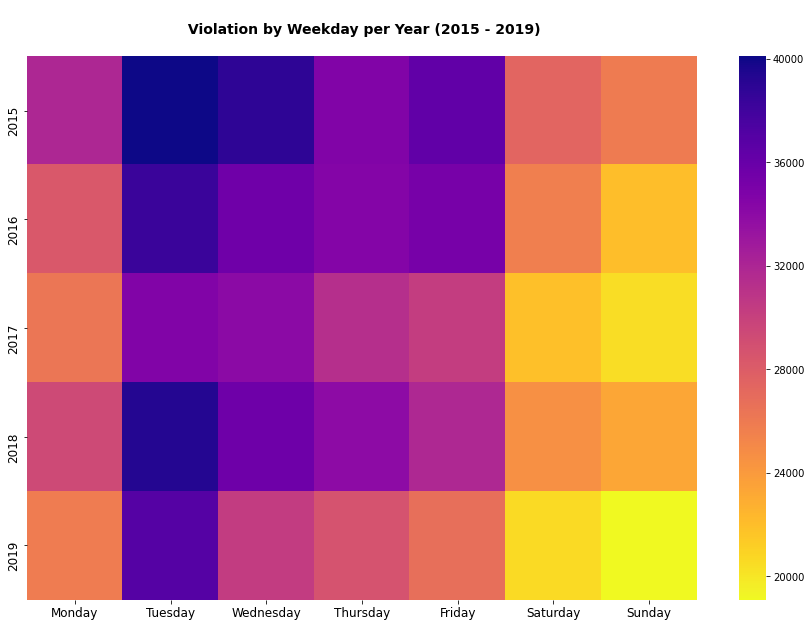

In [13]:
weekdays = ['Monday', 'Tuesday','Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday']
violationweekday = traffic_final_2019.groupby(['year', 'day']).size()
#Reshape using unstack() function in Pandas python: 
violationweekday = violationweekday.rename_axis(['year', 'day'])\
                               .unstack('day')\
                               .reindex(columns=weekdays)
plt.figure(figsize=(15,10))
sns.heatmap(violationweekday, cmap='plasma_r')
plt.title('\n Violation by Weekday per Year (2015 - 2019)\n', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('')
plt.ylabel('')
plt.savefig('images/violationsbyweekdayperyear.jpg')
plt.show()

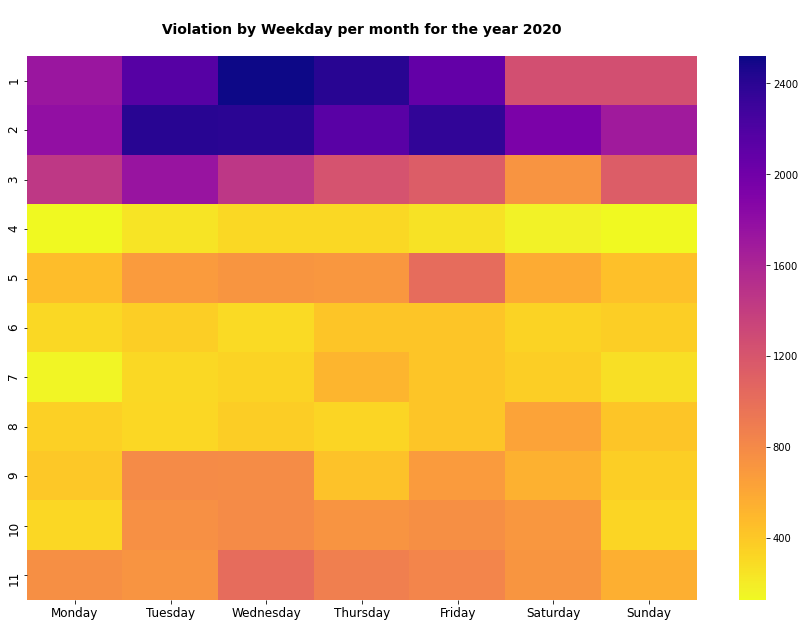

In [14]:
weekdays = ['Monday', 'Tuesday','Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday']
violationweekday = traffic_final_2020.groupby(['month', 'day']).size()
#Reshape using unstack() function in Pandas python: 
violationweekday = violationweekday.rename_axis(['year', 'day'])\
                               .unstack('day')\
                               .reindex(columns=weekdays)
plt.figure(figsize=(15,10))
sns.heatmap(violationweekday, cmap='plasma_r')
plt.title('\n Violation by Weekday per month for the year 2020 \n', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('')
plt.ylabel('')
plt.savefig('images/violationsbyweekdayperyear.jpg')
plt.show()

In [15]:
traffic_final.columns

Index(['DateOfStop', 'TimeOfStop', 'Agency', 'SubAgency', 'Description',
       'Location', 'Latitude', 'Longitude', 'Accident', 'Belts',
       'PersonalInjury', 'PropertyDamage', 'Fatal', 'CommercialLicense',
       'HAZMAT', 'CommercialVehicle', 'Alcohol', 'WorkZone', 'State',
       'VehicleType', 'Year_model', 'Make', 'Model', 'Color', 'ViolationType',
       'Charge', 'Article', 'ContributedToAccident', 'Race', 'Gender',
       'DriverCity', 'DriverState', 'DLState', 'ArrestType', 'Geolocation',
       'date', 'year', 'month', 'time', 'hour', 'day', 'season', 'Violation'],
      dtype='object')

In [16]:
#def get_summary_statistics(dataset):


#    mean = np.round(np.mean(dataset), 2)
#    median = np.round(np.median(dataset), 2)
#    min_value = np.round(dataset.min(), 2)
#    max_value = np.round(dataset.max(), 2)
#    quartile_1 = np.round(dataset.quantile(0.25), 2)
#    quartile_3 = np.round(dataset.quantile(0.75), 2)
#    # Interquartile range
#    iqr = np.round(quartile_3 - quartile_1, 2)
#     print('Min: %s' % min_value)
#     print('Mean: %s' % mean)# # 
#     print('Max: %s' % max_va# # lue# )
#     print('25th percentile: # # %s'#  % quartile_1)
#     print('Median: %s' % med# ia# n)
#     print('75th percentile: %s# # ' % quartile_3)
#     print('Interquartile ran# # ge (IQR): %s' % iqr)
  # # #   
# # # # print('\n\n summary statistics from 2015-2020')
# # # get_summary_statistics(traffic_final)
# # print('\n\nVersicolor summary statistics from 2015-2019')
# get_summary_statistics(traffic_final_2019)
# p# rint('\n\nVersicolor summary statistics for the year 2020')
# get_summary_statistics(traffic_final_2020)

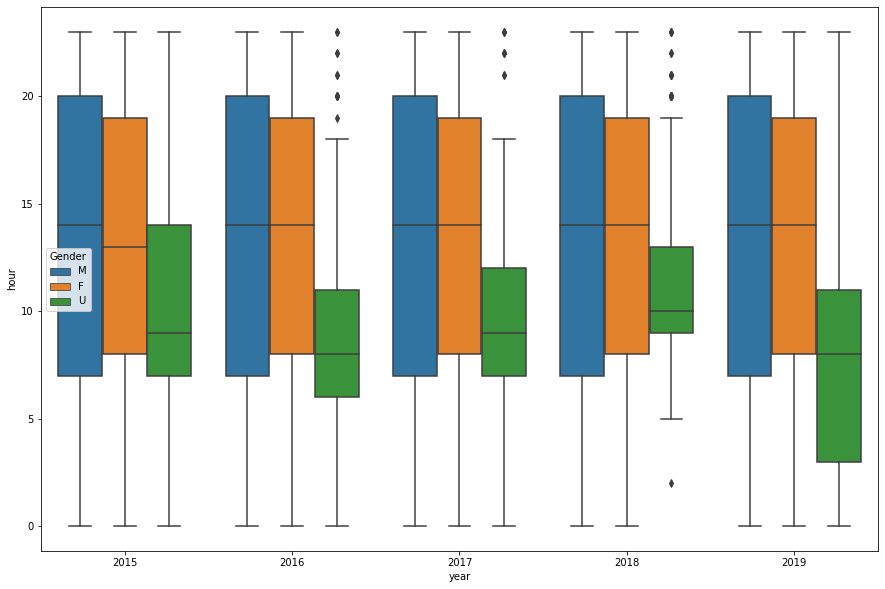

In [17]:
fig, ax = plt.subplots(figsize=(15, 10))  
sns.boxplot(x='year', y='hour', hue='Gender', data=traffic_final_2019, ax=ax)  
plt.show()  

# Machine Learning - Traffic Violation

In [18]:
#CRNM_ML = CRNM_new.replace({'InjurySeverity' : {'SUSPECTED MINOR INJURY' : 'SUSPECTED_M_INJURY' , 'POSSIBLE INJURY': 'POSSIBLE_INJURY', 'SUSPECTED SERIOUS INJURY' : 'SUSPECTED_S_INJURY', 'NO APPARENT INJURY' : 'NO_APPARENT_INJURY','FATAL INJURY' : 'FATAL_INJURY' }})
traffic_ML_2019 = traffic_final_2019.copy()
traffic_ML_2020 = traffic_final_2020.copy()

# Binomial Classification : Can we predict drivers that are male with a Machine Learning model?

In [19]:
# Create a DataFrame of female drivers
female_2020 = traffic_ML_2020[traffic_final_2020.Gender == 'F']

# Create a DataFrame of male drivers
male_2020 = traffic_ML_2020[traffic_final_2020.Gender == 'M']

# Create a DataFrame of female drivers
female_2019 = traffic_ML_2019[traffic_final_2019.Gender == 'F']

# Create a DataFrame of male drivers
male_2019 = traffic_ML_2019[traffic_final_2019.Gender == 'M']

# Compute the violation types by female drivers (as proportions)
print("Violation Type for females in the year 2020:\n", female_2020.ViolationType.value_counts())

print('-------------------------------')

# Compute the violation types by male drivers (as proportions)
print("Violation Type for males in the year 2020:\n", male_2020.ViolationType.value_counts())
print('-------------------------------')

# Compute the violations by female drivers (as proportions)
print("Violation Type for females from 2015-2019:\n", female_2019.ViolationType.value_counts())

print('-------------------------------')

# Compute the violations by male drivers (as proportions)
print("Violation Type for males from 2015-2019:\n", male_2019.ViolationType.value_counts())



Violation Type for females in the year 2020:
 Warning     12568
Citation     6691
ESERO         570
Name: ViolationType, dtype: int64
-------------------------------
Violation Type for males in the year 2020:
 Warning     22912
Citation    20481
ESERO        1435
Name: ViolationType, dtype: int64
-------------------------------
Violation Type for females from 2015-2019:
 Warning     206902
Citation    123985
ESERO        15734
Name: ViolationType, dtype: int64
-------------------------------
Violation Type for males from 2015-2019:
 Warning     363836
Citation    313890
ESERO        35408
Name: ViolationType, dtype: int64


In [20]:
count_male_2019 = len(traffic_ML_2019[traffic_final_2019['Gender']=='M'])
count_female_2019 = len(traffic_ML_2019[traffic_final_2019['Gender']=='F'])
perc_of_male_2019 = count_male_2019/(count_male_2019+count_female_2019)
print("percentage of male from 2015-2019 :", perc_of_male_2019*100)
perc_of_female_2019 = count_female_2019/(count_male_2019+count_female_2019)
print("percentage of female from 2015-2019 :", perc_of_female_2019*100)
print("........................................................................")
count_male_2020 = len(traffic_final_2020[traffic_final_2020['Gender']=='M'])
count_female_2020 = len(traffic_final_2020[traffic_final_2020['Gender']=='F'])
perc_of_male_2020 = count_male_2020/(count_male_2020+count_female_2020)
print("percentage of male in the year 2020 :", perc_of_male_2020*100)
perc_of_female_2020 = count_female_2020/(count_male_2020+count_female_2020)
print("percentage of female in the year 2020 :", perc_of_female_2020*100)

percentage of male from 2015-2019 : 67.29234587239503
percentage of female from 2015-2019 : 32.70765412760496
........................................................................
percentage of male in the year 2020 : 69.33201354841702
percentage of female in the year 2020 : 30.66798645158297


We observe hear that classes are imbalanced. Ratio of male to female instances is 67:32 (from 2015-2019). It is interesting to note that percentage of male increased in the year 2020 and decreased for female.

In [21]:
traffic_ML_2019_Gender=traffic_ML_2019[['ViolationType', 'Race', 'Color', 'VehicleType','Gender']]
traffic_ML_2019_Gender['Gender'] = np.where(traffic_ML_2019_Gender['Gender'].str.contains('M'), 1, 0)

traffic_ML_2020_Gender=traffic_ML_2020[['ViolationType', 'Race', 'Color', 'VehicleType','Gender']]
traffic_ML_2020_Gender['Gender'] = np.where(traffic_ML_2020_Gender['Gender'].str.contains('M'), 1, 0)

In [22]:
traffic_ML_2019_Gender.head()

,ViolationType,Race,Color,VehicleType,Gender
0,Citation,HISPANIC,RED,02 - Automobile,1
1,Warning,WHITE,SILVER,02 - Automobile,0
2,Warning,WHITE,BLACK,02 - Automobile,0
3,Citation,HISPANIC,BLACK,02 - Automobile,1
4,Warning,OTHER,WHITE,02 - Automobile,1


## Test and Train Data

For the performance of the model the data is split into the test data and train data. The data is split using the *train_test_split.* The data here is split in the ratio 80:20.

For the model prediction the logistic regression function is implemented by importing the logistic regression model in the sklearn module.

The model is then fit on the train set using the fit function. After this the prediction is performed using the prediction function.

In [23]:
# Split the data into a training and test set.
features_gender_2019=pd.get_dummies(traffic_ML_2019_Gender.drop('Gender',axis=1))
target_gender_2019 =np.array(traffic_ML_2019_Gender['Gender'])
X_train_g2019, X_test_g2019, y_train_g2019, y_test_g2019 = train_test_split(features_gender_2019,target_gender_2019 
                                             ,test_size=0.20, random_state=99)

features_gender_2020=pd.get_dummies(traffic_ML_2020_Gender.drop('Gender' ,axis=1))
target_gender_2020 =np.array(traffic_ML_2020_Gender['Gender'])
X_train_g2020, X_test_g2020, y_train_g2020, y_test_g2020 = train_test_split(features_gender_2020,target_gender_2020 
                                             ,test_size=0.20, random_state=99)

In [24]:
logmodel=LogisticRegression()
#logmodel=LogisticRegression(solver='liblinear', C=10.0)
## fit the model with data
logmodel.fit(X_train_g2019, y_train_g2019)
y_pred_g2019 = logmodel.predict(X_test_g2019)


print("Accuracy score using meterics accuracy score:\n")
print("Accuracy  %2.2f%%" % (metrics.accuracy_score(y_test_g2019, y_pred_g2019)*100))
print(".............................................................\n")
print("Accuracy score using logistic regression model:\n")
print("Score of our model is %2.2f%%" % (logmodel.score(X_train_g2019, y_train_g2019) * 100))

Accuracy score using meterics accuracy score:

Accuracy  67.30%
.............................................................

Accuracy score using logistic regression model:

Score of our model is 67.20%


In [25]:
print(classification_report(y_test_g2019,y_pred_g2019))

              precision    recall  f1-score   support

           0       0.50      0.01      0.02     69398
           1       0.67      1.00      0.80    142839

    accuracy                           0.67    212237
   macro avg       0.59      0.50      0.41    212237
weighted avg       0.62      0.67      0.55    212237



The classification report displays the **Precision, Recall , F1  and Support** scores for the model.

Precision score means the the level up-to which the prediction made by the model is precise. The precision for male is 0.67 and for female is 0.54.

Recall is the amount up-to which the model can predict the outcome. Recall for male is 1 and for female 0.01. 

In [26]:
logmodel.fit(X_train_g2020, y_train_g2020)
y_pred_g2020 = logmodel.predict(X_test_g2020)


print("Accuracy score using meterics accuracy score:\n")
print("Accuracy  %2.2f%%" % (metrics.accuracy_score(y_test_g2020, y_pred_g2020)*100))
print(".............................................................\n")
print("Accuracy score using logistic regression model:\n")
print("Score of our model is %2.2f%%" % (logmodel.score(X_train_g2020, y_train_g2020) * 100))

Accuracy score using meterics accuracy score:

Accuracy  68.86%
.............................................................

Accuracy score using logistic regression model:

Score of our model is 69.17%


In [27]:
print(classification_report(y_test_g2020,y_pred_g2020))

              precision    recall  f1-score   support

           0       0.49      0.01      0.02      4038
           1       0.69      0.99      0.81      8937

    accuracy                           0.69     12975
   macro avg       0.59      0.50      0.42     12975
weighted avg       0.63      0.69      0.57     12975



### Confusion Matrix

Confusion matrix is a table which describes the performance of a prediction model. A confusion matrix contains the actual values and predicted values. we can use these values to calculate the accuracy score of the model.

In [28]:
cnf_matrix_2019 = metrics.confusion_matrix(y_test_g2019,y_pred_g2019)
cnf_matrix_2019

array([[   578,  68820],
       [   571, 142268]], dtype=int64)

### Confusion matrix heatmap

In [32]:
#sns.heatmap(pd.DataFrame(confusion_matrix(y_test_g2019,y_pred_g2019)))
#plt.show()

In [39]:
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test_g2019, logmodel.predict(X_test_g2019))
fpr, tpr, thresholds = roc_curve(y_test_g2019, logmodel.predict_proba(X_test_g2019)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

ValueError: X has 60 features per sample; expecting 49

AUC score for the case is 0.50. AUC score 1 represents perfect classifier, and 0.5 is not good classifier. Thus, our model is not a very good classifier.

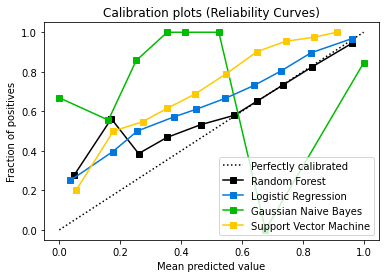

In [34]:
rf = RandomForestClassifier()
lr = LogisticRegression()
nb = GaussianNB()
svm = LinearSVC()
rf_probas = rf.fit(X_train_g2019, y_train_g2019).predict_proba(X_test_g2019)
lr_probas = lr.fit(X_train_g2019, y_train_g2019).predict_proba(X_test_g2019)
nb_probas = nb.fit(X_train_g2019, y_train_g2019).predict_proba(X_test_g2019)
svm_scores = svm.fit(X_train_g2019, y_train_g2019).decision_function(X_test_g2019)
probas_list = [rf_probas, lr_probas, nb_probas, svm_scores]
clf_names = ['Random Forest', 'Logistic Regression',
             'Gaussian Naive Bayes', 'Support Vector Machine']
skplt.metrics.plot_calibration_curve(y_test_g2019,
                                      probas_list,
                                      clf_names)
plt.show()

### Cumulative Gain Curve
The cumulative gains chart also used to determine the effectiveness of a binary classifier.

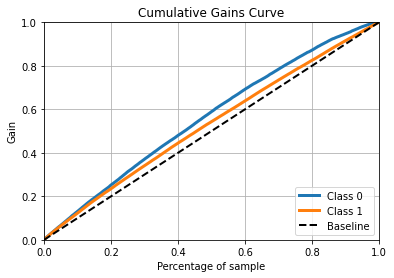

In [35]:
lr = LogisticRegression()
lr = lr.fit(X_train_g2019, y_train_g2019)
y_probas_g2019 = lr.predict_proba(X_test_g2019)
skplt.metrics.plot_cumulative_gain(y_test_g2019, y_probas_g2019)
plt.show()

In [ ]:
!pip install plot_metric

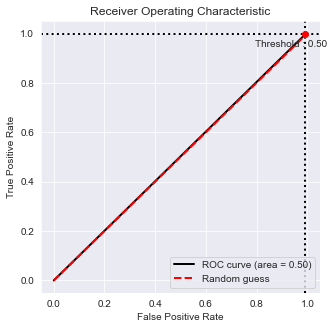

In [44]:
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(y_test_g2019, y_pred_g2019, labels=["Class 0", "Class 1"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

###### When AUC is approximately 0.5, model has no discrimination capacity to distinguish between positive class and negative class. 

When AUC=0.5, then the classifier is not able to distinguish between Positive and Negative class points. Meaning either the classifier is predicting random class or constant class for all the data points.

# Multinomial Classification : Can we predict Violation Type?

In [45]:
# Split the data into a training and test set.
features_vtype_2019=pd.get_dummies(traffic_ML_2019_Gender.drop('ViolationType' ,axis=1))
target_vtype_2019 = np.array((traffic_ML_2019_Gender['ViolationType']))

X_train_vt2019, X_test_vt2019, y_train_vt2019, y_test_vt2019 = train_test_split(features_vtype_2019,target_vtype_2019 
                                             ,test_size=0.20, random_state=99)

features_vtype_2020=pd.get_dummies(traffic_ML_2020_Gender.drop('ViolationType' ,axis=1))
target_vtype_2020 =np.array(traffic_ML_2020_Gender['ViolationType'])

X_train_vt2020, X_test_vt2020, y_train_vt2020, y_test_vt2020 = train_test_split(features_vtype_2020,target_vtype_2020 
                                             ,test_size=0.20, random_state=99)

In [46]:
#fit model fort multi class
#mult_logmodel = OneVsRestClassifier(LogisticRegression())
mult_logmodel = LogisticRegression(solver='lbfgs',multi_class='multinomial')
mult_logmodel.fit(X_train_vt2019, y_train_vt2019)
y_pred_vt2019 = mult_logmodel.predict(X_test_vt2019)
y_pred_prob_vt2019 = mult_logmodel.predict_proba(X_test_vt2019)

print("Accuracy score using meterics accuracy score:\n")
print("Accuracy  %2.2f%%" % (metrics.accuracy_score(y_test_vt2019, y_pred_vt2019) * 100))

print("Accuracy score using multinominal logistic regression model:\n")
print("Score of our model is %2.2f%%" % (mult_logmodel.score(X_train_vt2019, y_train_vt2019) * 100))



Accuracy score using meterics accuracy score:

Accuracy  55.54%
Accuracy score using multinominal logistic regression model:

Score of our model is 55.51%


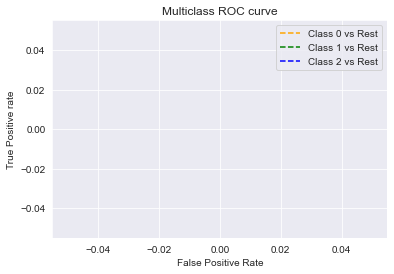

In [47]:
fpr = {}
tpr = {}
thresh = {}
n_class = 3
for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_vt2019, y_pred_prob_vt2019[:,i], pos_label=i)
    
# plotting  
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')

In [48]:
cnf_matrix_2019_multiclass = metrics.confusion_matrix(y_test_vt2019,y_pred_vt2019)
cnf_matrix_2019_multiclass

array([[20569,    39, 66889],
       [ 2403,   123,  7788],
       [17164,    87, 97175]], dtype=int64)

### ROC Curve for multi-class

In [ ]:
#visualizer = ROCAUC(mult_logmodel, classes=["Warning", "Citation", "ESERO"])

#visualizer.fit(X_train_vt2019, y_train_vt2019)        # Fit the training data to the visualizer
#visualizer.score(X_test_vt2019, y_test_vt2019)        # Evaluate the model on the test data
#visualizer.show()                       # Finalize and render the figure
#roc_auc(multlogmodel, X_train_vt2019, y_train_vt2019, X_test_vt2019=X_test_vt2019, y_test_vt2019=y_test_vt2019, classes=["Warning", "Citation", "ESERO"])

In [ ]:
traffic_ML_2019_Gender['ViolationType'].value_counts()

In [ ]:
#print("ROC score",roc_auc_score(y_test, y_pred))
#print("F1 score",f1_score(y_test, y_pred))

# Multinomial Classification : Can we predict Vehicle Type?

In [ ]:
# Split the data into a training and test set.
from sklearn.multiclass import OneVsRestClassifier

features_vehicle_2019=pd.get_dummies(traffic_ML_2019_Gender.drop('VehicleType' ,axis=1))
target_vehicle_2019 = np.array((traffic_ML_2019_Gender['VehicleType']))

X_train_V2019, X_test_V2019, y_train_V2019, y_test_V2019 = train_test_split(features_vehicle_2019,target_vehicle_2019 
                                             ,test_size=0.20, random_state=99)

features_vehicle_2020=pd.get_dummies(traffic_ML_2020_Gender.drop('VehicleType' ,axis=1))
target_vehicle_2020 =np.array(traffic_ML_2020_Gender['VehicleType'])

X_train_V2020, X_test_V2020, y_train_V2020, y_test_V2020 = train_test_split(features_vehicle_2020,target_vehicle_2020 
                                             ,test_size=0.20, random_state=99)

In [ ]:
#fit model fort multi class
#mult_logmodel = OneVsRestClassifier(LogisticRegression())
mult_logmodel = LogisticRegression(solver='lbfgs',multi_class='multinomial')
mult_logmodel.fit(X_train_V2019, y_train_V2019)
y_pred_V2019 = mult_logmodel.predict(X_test_V2019)
y_pred_prob_V2019 = mult_logmodel.predict_proba(X_test_V2019)

print("Accuracy score using meterics accuracy score:\n")
print("Accuracy  %2.2f%%" % (metrics.accuracy_score(y_test_V2019, y_pred_V2019) * 100))

print("Accuracy score using logistic regression model:\n")
print("Score of our model is %2.2f%%" % (mult_logmodel.score(X_train_V2019, y_train_V2019) * 100))


**The score is the percentage of correct predictions in the test set. 90% is pretty good.**

In [ ]:
#y_pred_prob_V2019_a = mult_logmodel.predict_proba(X_test_V2019)[:,0]# for calculating the probability of the first class
#y_pred_prob_V2019_b = mult_logmodel.predict_proba(X_test_V2019)[:,1] # for calculating the probability of the second class

#fpr, tpr, thresholds = metrics.roc_curve(1-y_test_V2019,y_pred_prob_V2019_a)
#auc=metrics.auc(fpr, tpr)
#print("auc for the first class",auc)

#fpr2, tpr2, thresholds2 = metrics.roc_curve(y_test_V2019,y_pred_brob_V2019_b)
#auc2=metrics.auc(fpr2, tpr2)
#print("auc for the second class",auc2)

# ploting the roc curve
#plt.plot(fpr,tpr)
#plt.plot(fpr2,tpr2)

#plt.xlim([0.0,1.0])
#plt.ylim([0.0,1.0])
#plt.title('Roc curve')
#plt.xlabel('False positive rate')
#plt.ylabel('True positive rate')
#plt.legend(loc="lower right")
#plt.show()

# Crash Incident Data
https://data.montgomerycountymd.gov/Public-Safety/Crash-Reporting-Incidents-Data/bhju-22kf

https://data.montgomerycountymd.gov/Public-Safety/Crash-Reporting-Non-Motorists-Data/n7fk-dce5

# 2. Crash Reporting – Motorists Data 

In [ ]:
    # Reading csv file
    #CRI= pd.read_csv("Crash_Reporting_-_Incidents_Data.csv")
    
    ## Downloading & Reading csv file from website
    url_CRI = 'https://data.montgomerycountymd.gov/api/views/bhju-22kf/rows.csv?accessType=DOWNLOAD'
    CRI = pd.read_csv(url_CRI,low_memory=False)

In [ ]:
"""" UseFeatues() Function when called, returns a dataframe with additional features"""

def useFeatures(CRI):

    ## Formatting the Date
    
    # Confirm the date column is in datetime format
    CRI['Crash Date/Time'] = pd.to_datetime(CRI['Crash Date/Time'])
   
    # creating  new columns: date, year, month, day, time 
    CRI['date'] = pd.to_datetime(CRI['Crash Date/Time'])
    CRI['year'] = CRI['Crash Date/Time'].dt.year
    CRI['month'] = CRI['Crash Date/Time'].dt.month
    CRI['time'] = CRI['Crash Date/Time'].dt.time
    CRI['hour'] = CRI['Crash Date/Time'].dt.hour
    #CRI['day'] = CRI['Crash Date/Time'].dt.weekday_name
    CRI['day'] = CRI['Crash Date/Time'].dt.day_name()
    
    CRI = CRI.sort_values(by='date')
    

    
    ## Filtering the Desired Date Range - 2015 to 2020 ##
    CRI = CRI[CRI.date >='01/01/2015']
    CRI = CRI[CRI.date <'12/02/2020']
    CRI = CRI.reset_index(drop=True)
    
    CRI['season']= "Fall"
    CRI.loc[(CRI['month'] < 3) | (CRI['month'] >= 12), "season"] = 'Winter'
    CRI.loc[(CRI['month'] < 6) & (CRI['month'] >= 3), "season"] = 'Spring'
    CRI.loc[(CRI['month'] < 9) & (CRI['month'] >= 6), "season"] = 'Summer'
    
    ## Hour status
    ##traffic["hourStatus"] = "Evening"
    ## traffic.loc[( traffic["hour"] < 18) & ( traffic["wdayStatus"] == "Weekday"), "hourStatus"]="WorkHour"
    
    #Creating a new column to count the total number of violation
    CRI['crash'] = pd.Series(1, index=CRI.index)
    
    return CRI

In [ ]:
# All the above features are stored in new data frame "CRI_features"
CRI_features = useFeatures(CRI)

In [ ]:
#clf = RandomForestClassifier(n_estimators=50, random_state=23)
#model = clf.fit(X_train_g2019, y_train_g2019)

# Use predict_proba to predict probability of the class
#y_pred = clf.predict_proba(X_test_g2019)[:,1]


In [ ]:
#bc = BinaryClassification(y_test_g2019, y_pred_g2019, labels=["Class 0", "Class 1"])

# Figures
#plt.figure(figsize=(15,10))
#plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
#bc.plot_roc_curve()
#plt.subplot2grid((2,6), (0,2), colspan=2)
#bc.plot_precision_recall_curve()
#plt.subplot2grid((2,6), (0,4), colspan=2)
#bc.plot_class_distribution()
#plt.subplot2grid((2,6), (1,1), colspan=2)
#bc.plot_confusion_matrix()
#plt.subplot2grid((2,6), (1,3), colspan=2)
#bc.plot_confusion_matrix(normalize=True)
#plt.show()
#bc.print_report()